In [4]:
import pandas as pd
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from scipy import stats
import numpy as np
from scipy.stats import skew, boxcox

In [5]:
warnings.filterwarnings('ignore')
dir = "../data"

In [6]:
train_data = pd.read_csv(os.path.join(dir, "train.csv"))
train_data.shape
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [14]:
def cont_selector(df):
    return df.select_dtypes(include=['number']).columns

def cat_selector(df):
    return df.select_dtypes(exclude=['number']).columns

def cast_to_cat(df, features):
    for feature in features:
        df[feature] = df[feature].astype('category')

In [16]:
print(cont_selector(train_data))
print(cat_selector(train_data))

Index(['id', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'],
      dtype='object')
Index(['Sex'], dtype='object')


In [20]:
def plot_missing_data(df):
    counts = df.isnull().sum()
    per = counts/float(df.shape[0])
    df_missing = pd.DataFrame({'feature':counts.index, 'MissingValuePercent':per})
    df_missing.sort_values(by=['MissingValuePercent'], ascending=True, inplace=True)
    df_missing.set_index('feature', inplace=True)
    df_missing.plot(kind='barh', figsize=(25, 25))

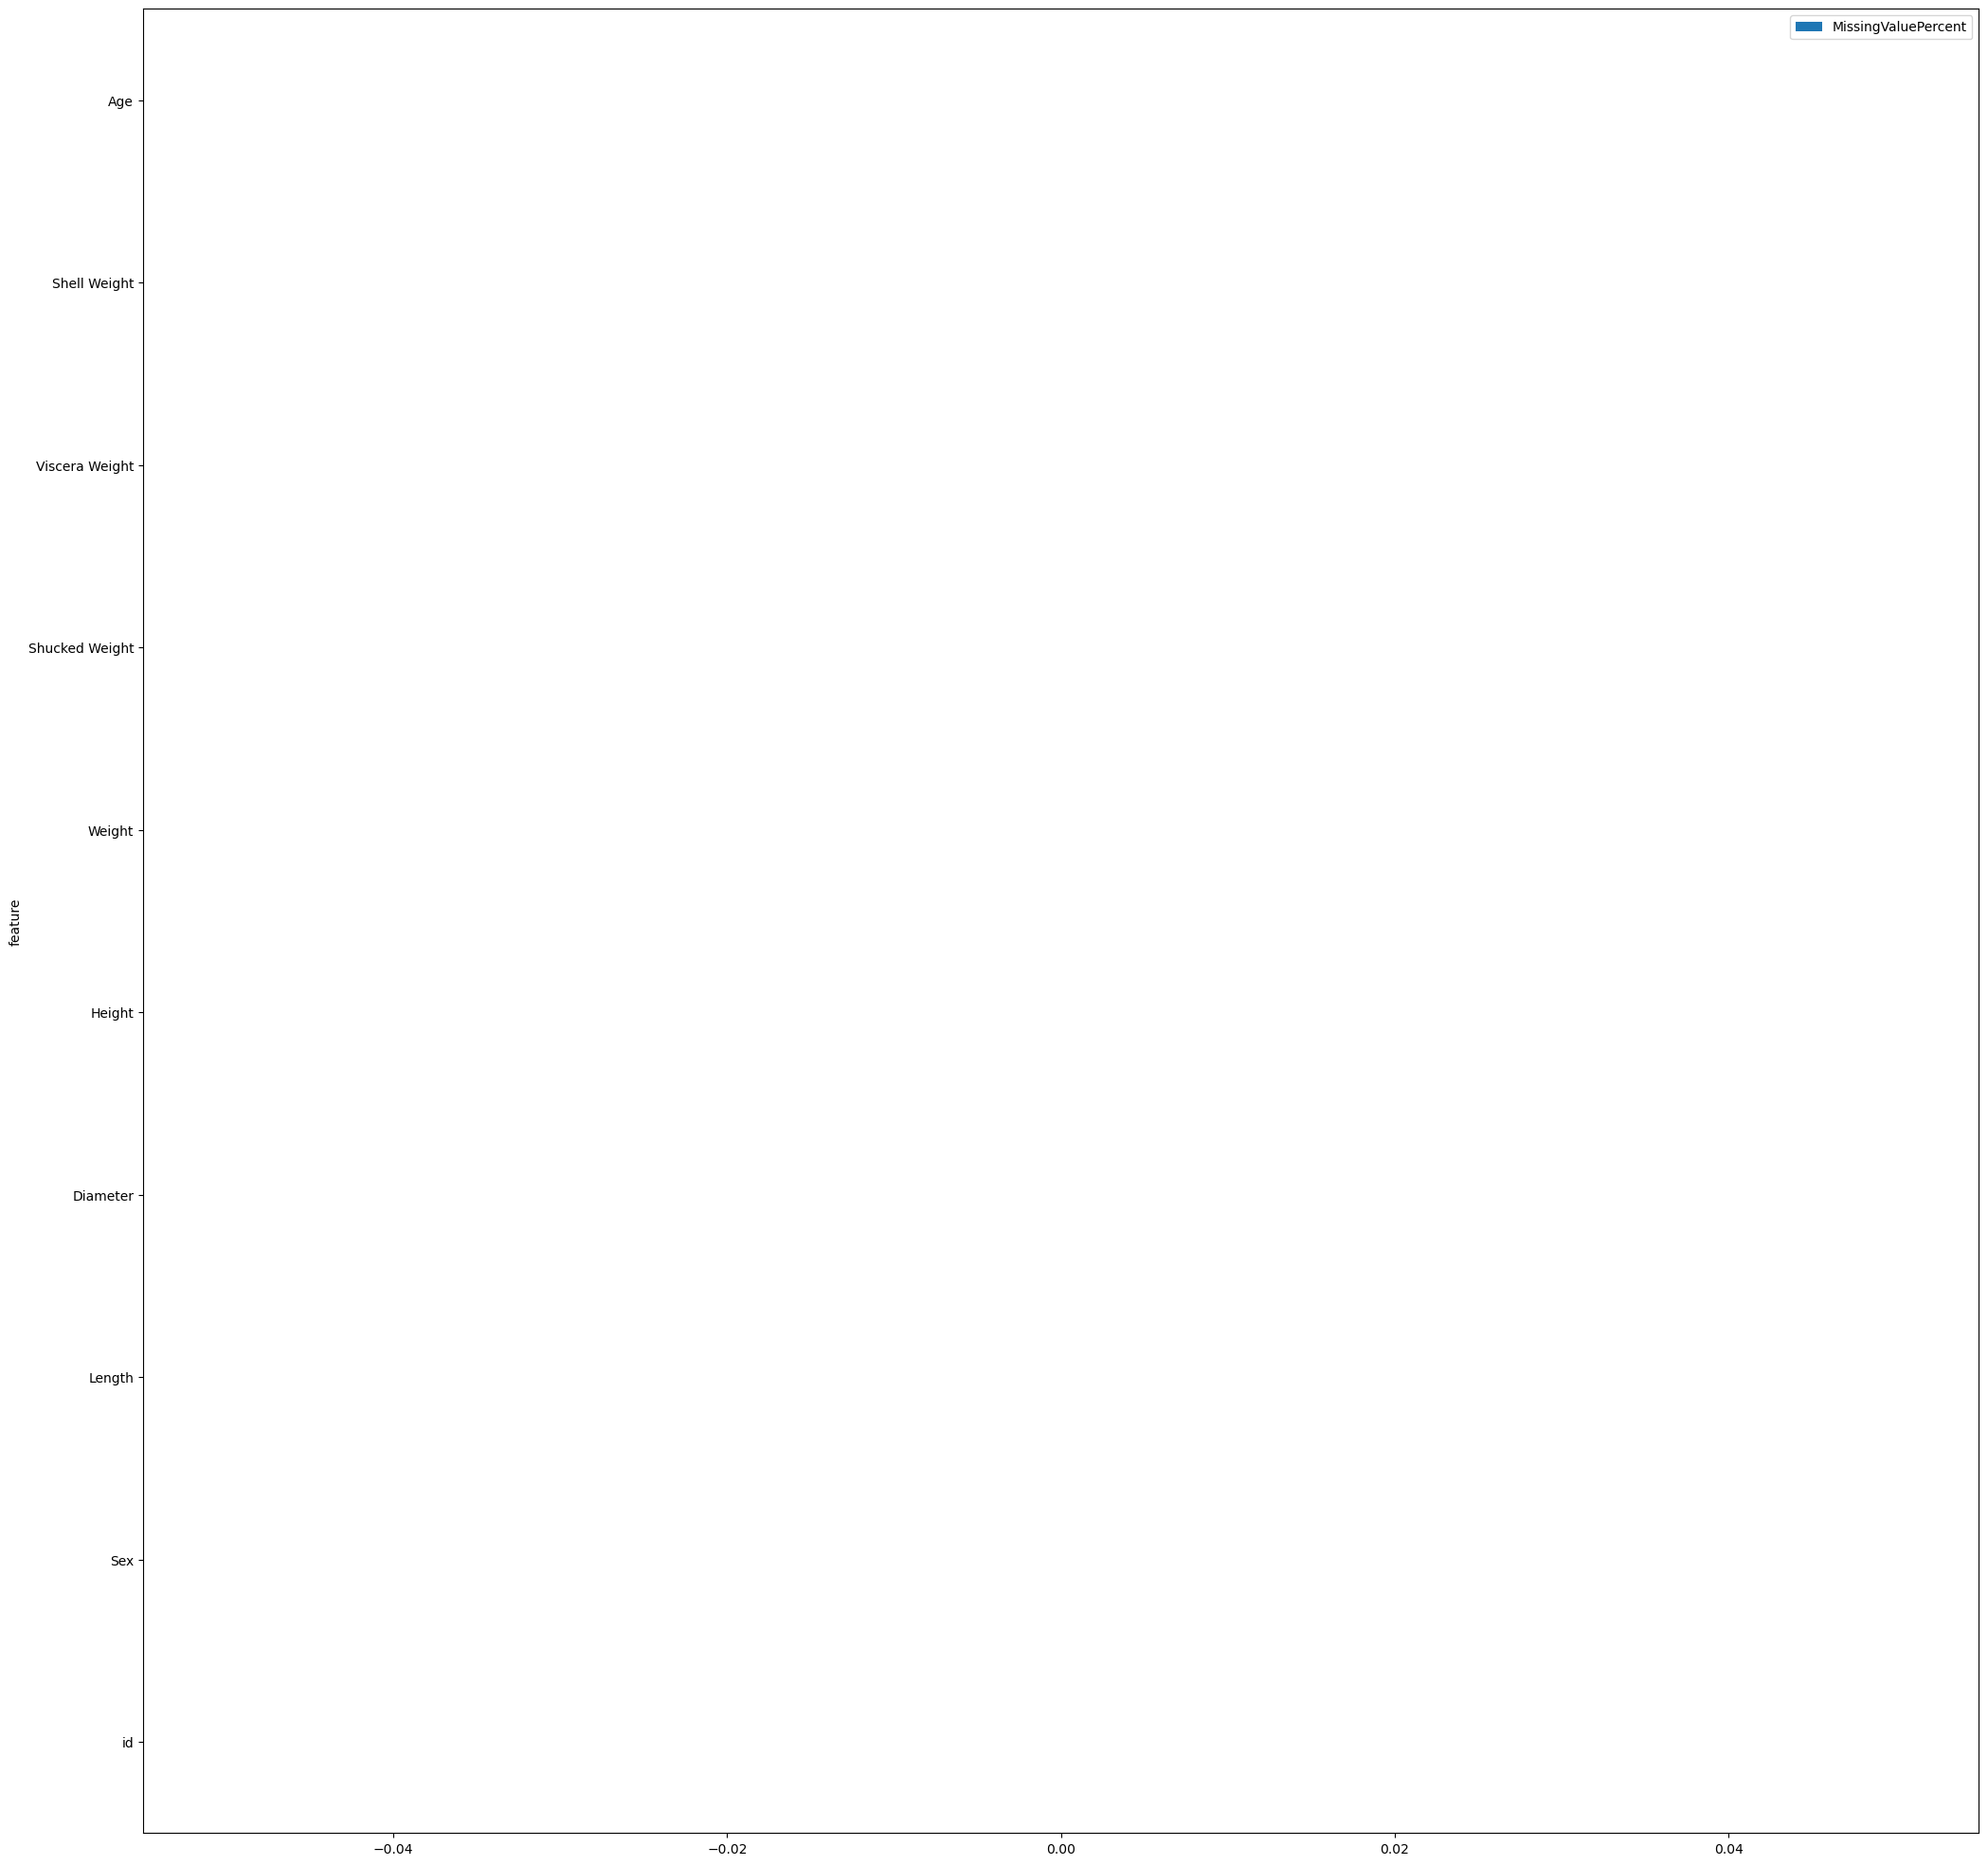

In [22]:
plot_missing_data(train_data)

In [29]:
# explore target variable
train_data['Age'].describe()

count    74051.000000
mean         9.967806
std          3.175189
min          1.000000
25%          8.000000
50%         10.000000
75%         11.000000
max         29.000000
Name: Age, dtype: float64

<Axes: >

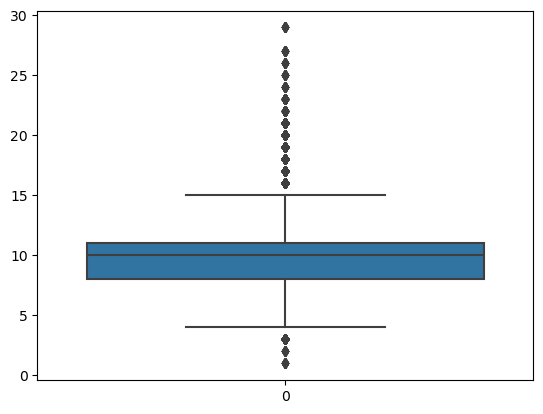

In [32]:
sns.boxplot(train_data['Age'])

<Axes: xlabel='Age', ylabel='Count'>

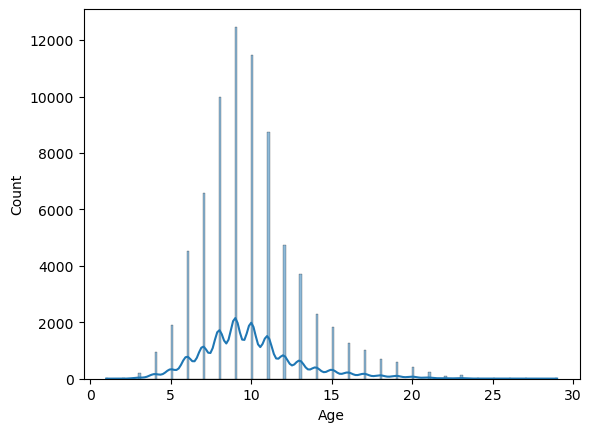

In [35]:
sns.histplot(train_data['Age'], kde=True)

Index(['Sex'], dtype='object')


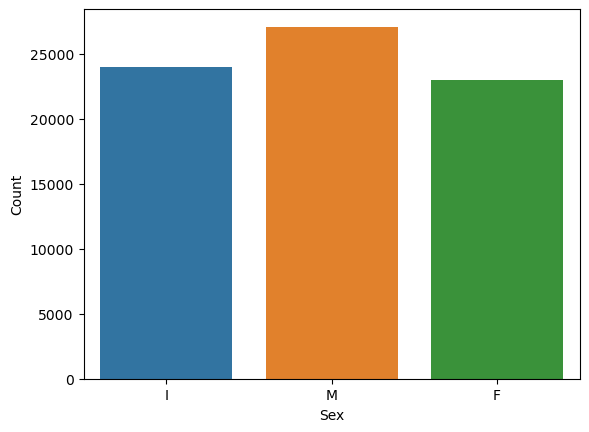

In [38]:
#Explore categorical features
cat_features = cat_selector(train_data)
print(cat_features)
for feature in cat_features:
    sns.countplot(x=feature,data=train_data)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

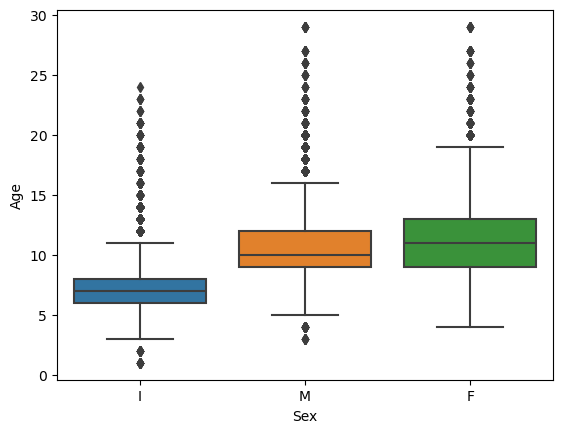

In [42]:
#Explore categorical features vs target relationships
for feature in cat_selector(train_data):
    sns.boxplot(x=feature, y='Age', data=train_data)
    plt.xlabel(feature)
    plt.ylabel('Age')
    plt.show()

['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']


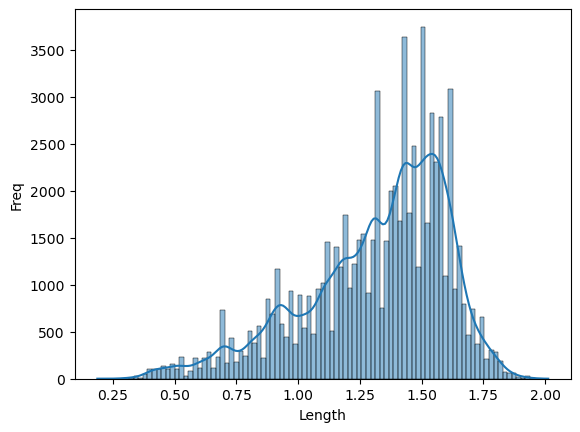

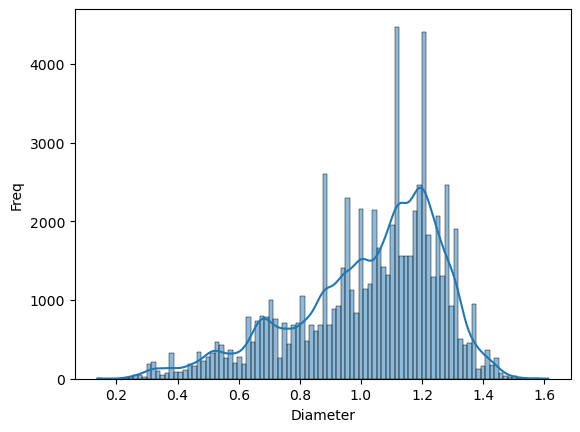

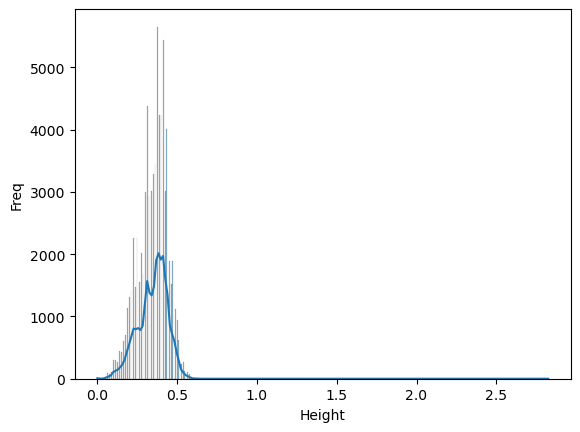

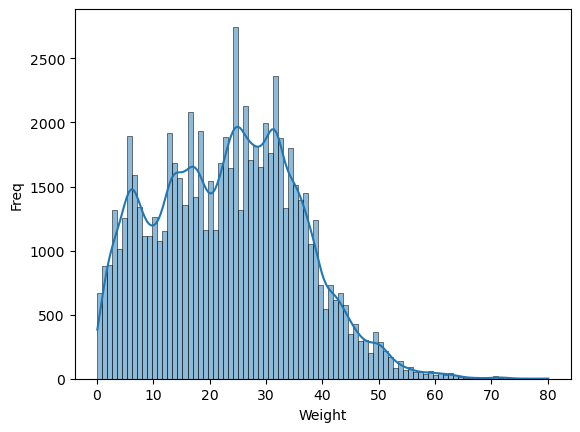

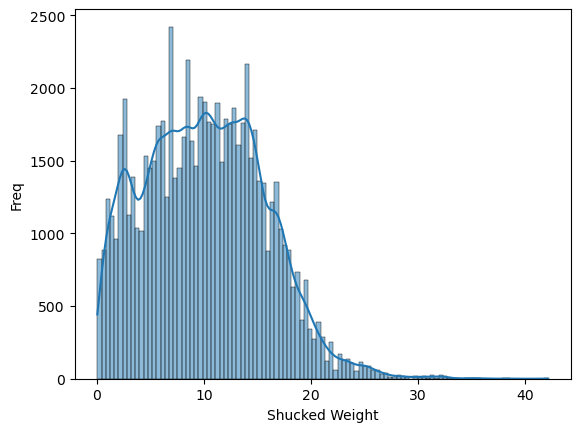

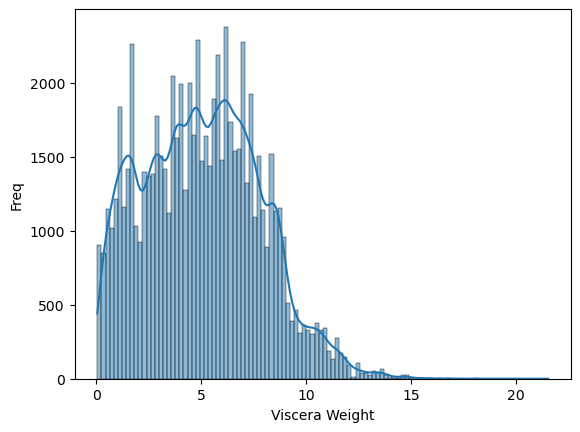

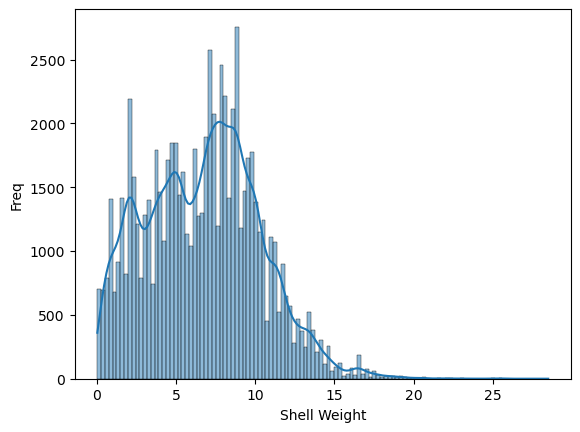

In [48]:
#Explore continuous features
cont_dist_features=[]
for feature in cont_selector(train_data):
    if len(train_data[feature].unique()) > 25 and feature not in ['id', 'Age']:
        cont_dist_features.append(feature)
print(cont_dist_features)

for feature in cont_dist_features:
    sns.histplot(train_data[feature], kde=True)
    plt.xlabel(feature)
    plt.ylabel('Freq')
    plt.show()

In [51]:
#Explore continuous features vs target relationships
df_cont_features = train_data[cont_selector(train_data)]
print(df_cont_features.shape)
corr = df_cont_features.corr()
corr

(74051, 9)


,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,1.000000,0.000165,0.000290,0.000967,-0.000910,-0.000801,-0.000640,-0.000816,0.000089
Length,0.000165,1.000000,0.989437,0.918352,0.936374,0.915516,0.917855,0.916957,0.612843
Diameter,0.000290,0.989437,1.000000,0.921353,0.938249,0.914199,0.918351,0.922688,0.621256
Height,0.000967,0.918352,0.921353,1.000000,0.901775,0.864083,0.883127,0.903398,0.638067
Weight,-0.000910,0.936374,0.938249,0.901775,1.000000,0.971267,0.971062,0.965525,0.601195
Shucked Weight,-0.000801,0.915516,0.914199,0.864083,0.971267,1.000000,0.942626,0.910398,0.503320
Viscera Weight,-0.000640,0.917855,0.918351,0.883127,0.971062,0.942626,1.000000,0.933919,0.576808
Shell Weight,-0.000816,0.916957,0.922688,0.903398,0.965525,0.910398,0.933919,1.000000,0.663473
Age,0.000089,0.612843,0.621256,0.638067,0.601195,0.503320,0.576808,0.663473,1.000000


In [55]:
def plot_corr_heatmap(corr):
    mask = np.triu(corr)
    plt.figure(figsize=(50, 50))
    heatmap = sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm', linewidths=1, mask=mask, cbar=True)
    heatmap.set_title('Correlation Heatmap', fontsize=40)
    heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 25, rotation=0)
    heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 25, rotation=70)
    plt.show()

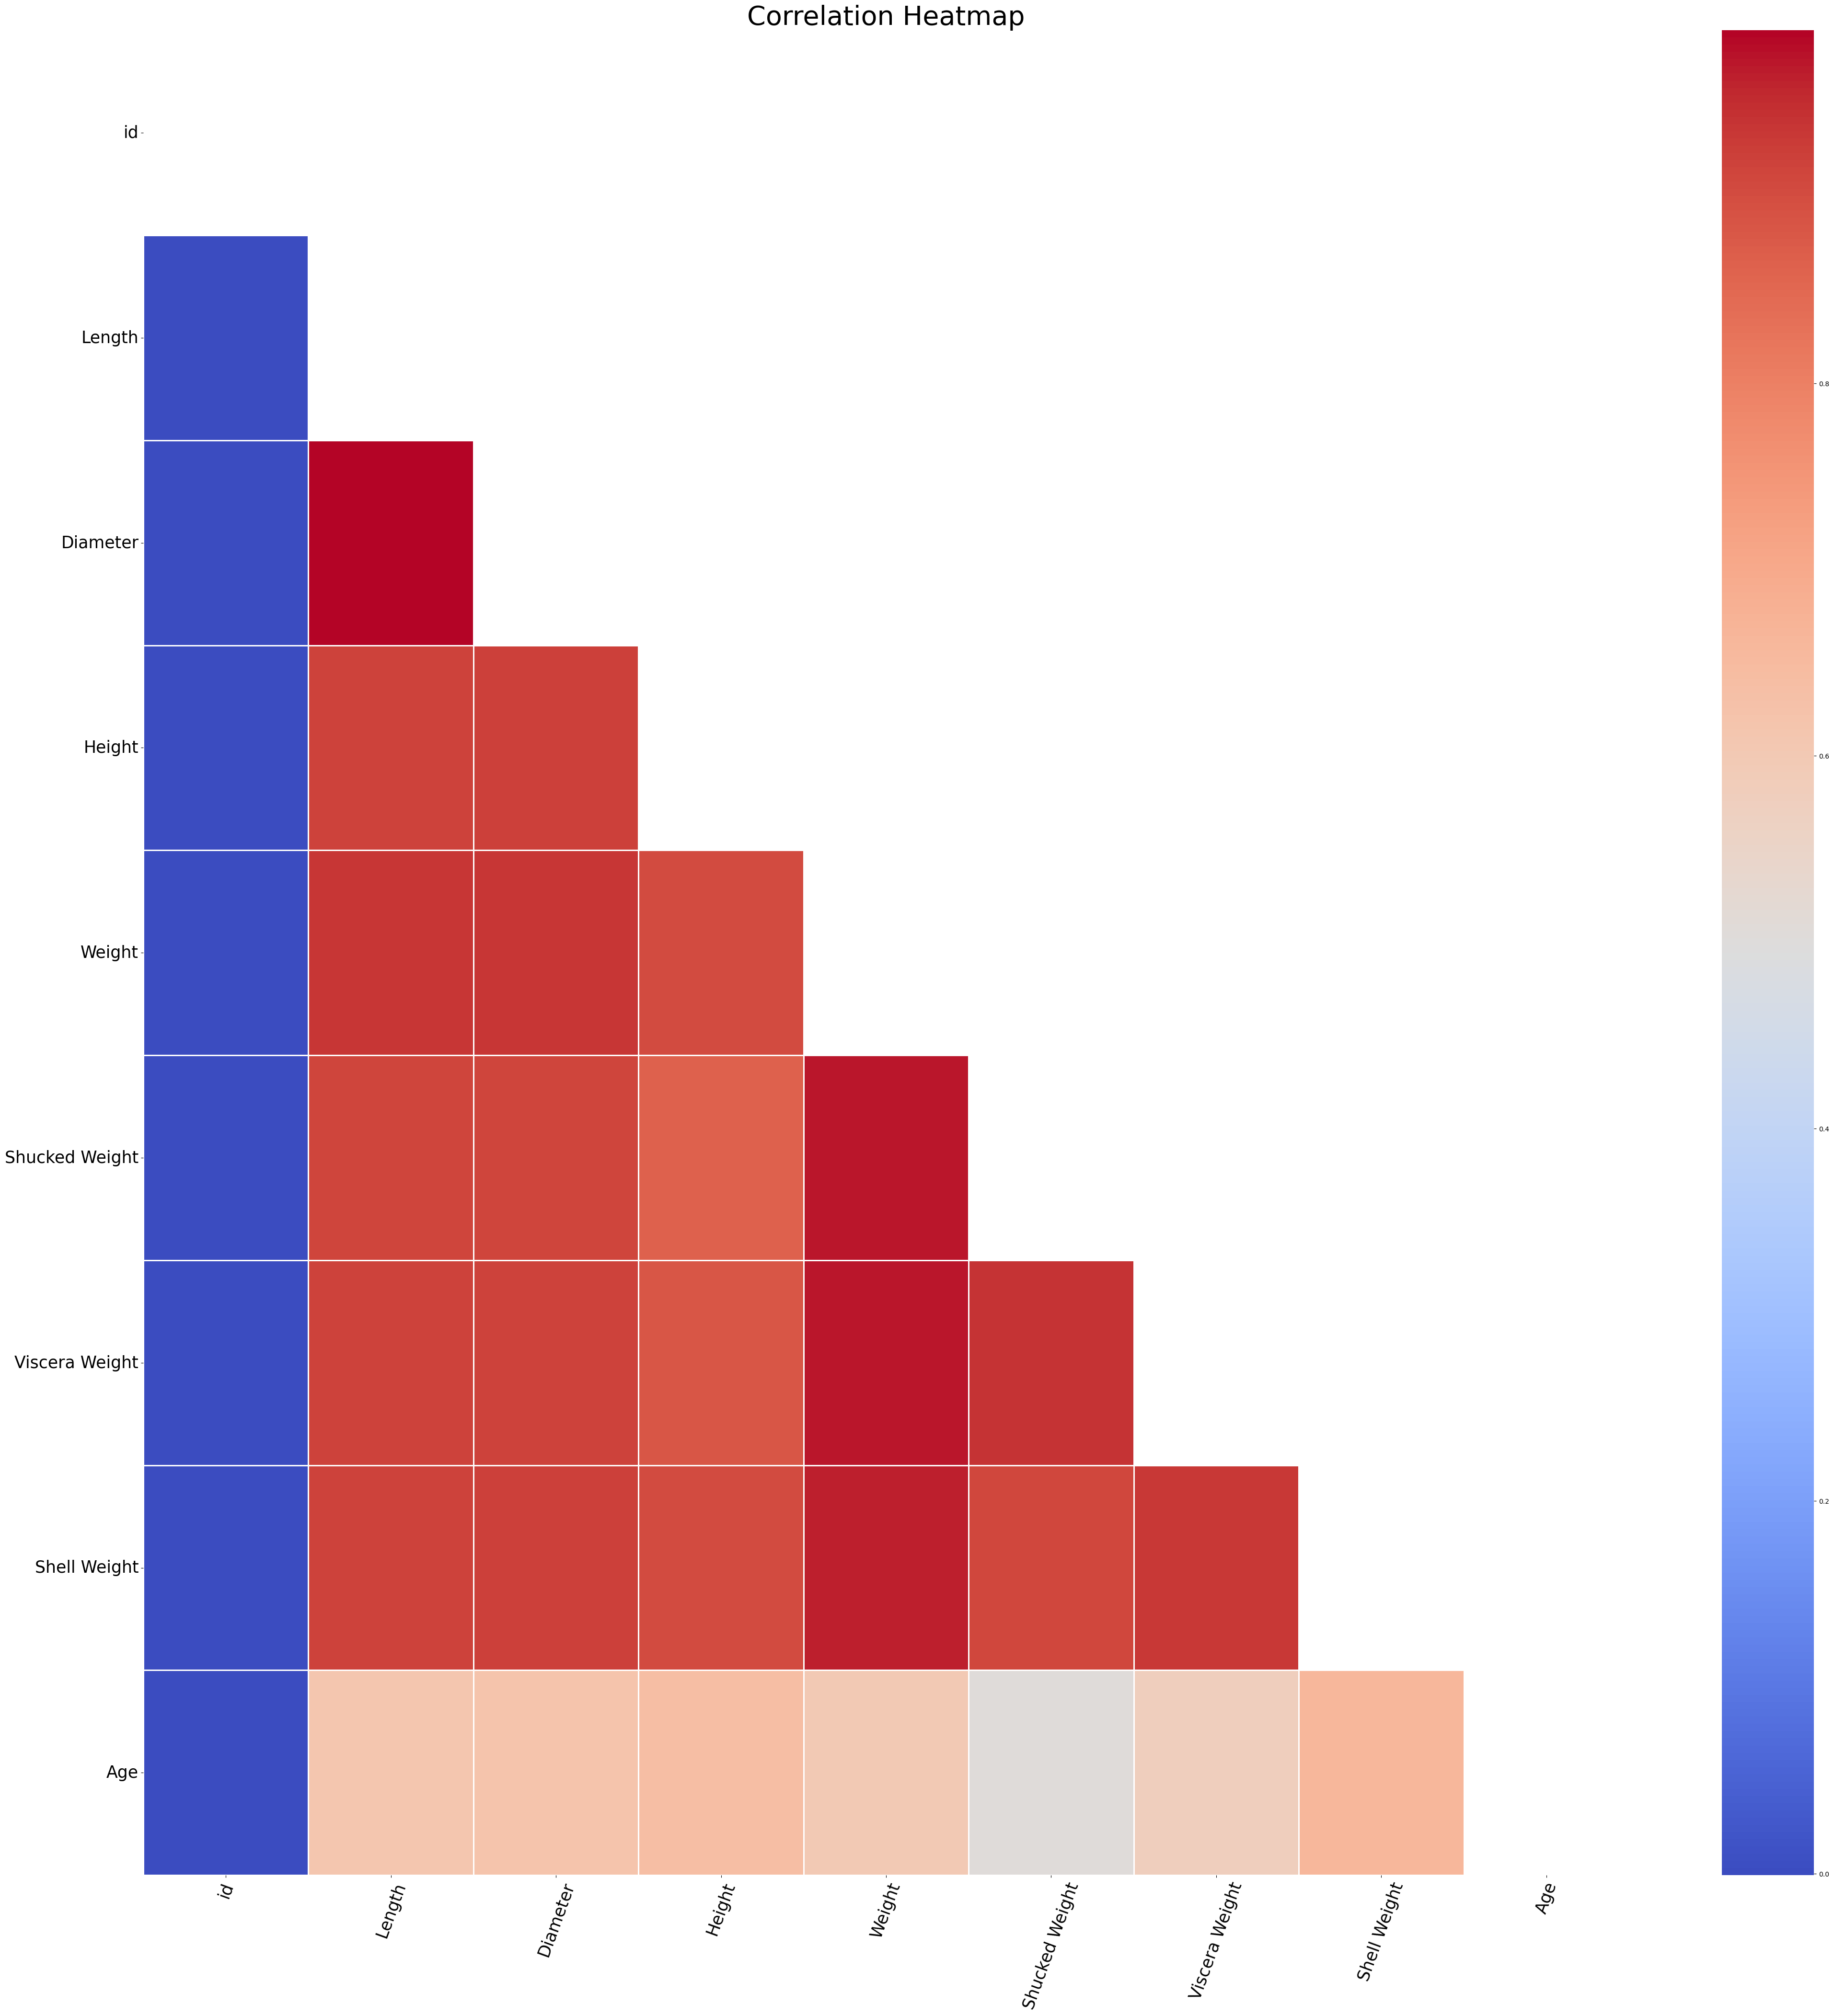

In [57]:
plot_corr_heatmap(corr)

In [62]:
df = corr.nlargest(corr.shape[1], 'Age')['Age']
df.head(corr.shape[1])

Age               1.000000
Shell Weight      0.663473
Height            0.638067
Diameter          0.621256
Length            0.612843
Weight            0.601195
Viscera Weight    0.576808
Shucked Weight    0.503320
id                0.000089
Name: Age, dtype: float64